# AON and ACTION Second (Group) Level Model

Master Thesis: **Modulation of the Action Observation Network - Investigating Action, Actor and Observer Factors in an fMRI Study**

Author: Olaf Borghi olafborghi@gmail.com

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [ ]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype import Node, Workflow
from nipype.interfaces import fsl
from nilearn.glm.second_level import SecondLevelModel 
from nilearn.glm import threshold_stats_img
from nilearn import plotting, datasets, image
from nilearn.plotting import plot_design_matrix
from nilearn.image import math_img
from nilearn.maskers import MultiNiftiMasker
from pathlib import Path
from pprint import pprint
from glob import glob
from atlasreader import get_statmap_info
print(nl.__version__) # print nilearn version

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

0.9.2


/usr/local/lib/python3.8/dist-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


**Set fixed parameters**

In [180]:
# fixed folders
basedir = Path("/home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"

# make folder to store mni template
if not os.path.exists(outputdir / "masks_templates"):
    os.makedirs(outputdir / "masks_templates")
masks_templates_dir = outputdir / "masks_templates"

# make folders for second level output
if not os.path.exists(outputdir / "second_level"):
    os.makedirs(outputdir / "second_level")
second_level_dir = outputdir / "second_level"

if not os.path.exists(second_level_dir / "AON-task"):
    os.makedirs(second_level_dir / "AON-task")
AON_second_level_dir = second_level_dir / "AON-task"

if not os.path.exists(second_level_dir / "action-task"):
    os.makedirs(second_level_dir / "action-task")
action_second_level_dir = second_level_dir / "action-task"

**Import functions**

I mainly used them for the first level model, but they can also be helpful to load some data for the second level model.

In [70]:
# I defined a number of functions that help me to import the data files from all subjects in a python script
import flm_helper_functions as flm_helpers
# let's look at the documentation of one of the functions
?flm_helpers.MyMRIImages

Signature: flm_helpers.MyMRIImages(paths)
Docstring:
Returns a dictionary with the functional or anatomical MRI images of each subject
loaded as a nib.img
Inputs: A list of paths to the functional/anatomical images, ordered by subject number
File:      ~/mnt/p/userdata/olafb99/shared/03_AON_ACTION/02_scripts/flm_helper_functions.py
Type:      function


## AON Second Level Model

Let's start with the second level model of the Action Observation Task.

**Load the anatomical data**

In [207]:
# store the paths of the warped anatomical images of all subjects in a list and load them using the function
anat_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/reg/highres2standard.nii.gz"))
anat_dict = flm_helpers.MyMRIImages(anat_paths)

# load the MNI template
template = datasets.load_mni152_template(resolution=1)

# store the MNI template also locally
mni_image_path = f"{masks_templates_dir}/mni_template_1mm.nii.gz"
template.to_filename(mni_image_path)

**Load the contrast maps of interest**

In [72]:
## Action observation contrast 


## contrasts to baseline

# all action observation - baseline
cmaps_aon = sorted(
    glob(f"{AON_first_level_dir}/main-baseline/*.nii.gz",
         recursive=True)
)

# human transitive - baseline
cmaps_transitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_transitive-baseline/*.nii.gz",
         recursive=True)
)

# human intransitive - baseline
cmaps_intransitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_intransitive-baseline/*.nii.gz",
         recursive=True)
)

# dog transitive - baseline
cmaps_transitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_transitive-baseline/*.nii.gz",
         recursive=True)
)

# dog intransitive - baseline
cmaps_intransitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_intransitive-baseline/*.nii.gz",
         recursive=True)
)

## Transitive - intransitive contrast

# dog and human actor
cmaps_transitive_intransitive = sorted(
    glob(f"{AON_first_level_dir}/transitive-intransitive/*.nii.gz",
         recursive=True)
)

# human actor
cmaps_transitive_intransitive_human = sorted(
    glob(f"{AON_first_level_dir}/human_transitive-intransitive/*.nii.gz",
         recursive=True)
)

# dog actor
cmaps_transitive_intransitive_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_transitive-intransitive/*.nii.gz",
         recursive=True)
)


## Intransitive - transitive contrast

# dog and human actor
cmaps_intransitive_transitive = sorted(
    glob(f"{AON_first_level_dir}/intransitive-transitive/*.nii.gz",
         recursive=True)
)

# human actor
cmaps_intransitive_transitive_human = sorted(
    glob(f"{AON_first_level_dir}/human_intransitive-transitive/*.nii.gz",
         recursive=True)
)

# dog actor
cmaps_intransitive_transitive_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_intransitive-transitive/*.nii.gz",
         recursive=True)
)

## Human - dog contrast

cmaps_human_dog = sorted(
    glob(f"{AON_first_level_dir}/human-dog/*.nii.gz",
         recursive=True)
)

## Dog - human contrast

cmaps_dog_human = sorted(
    glob(f"{AON_first_level_dir}/dog-human/*.nii.gz",
         recursive=True)
)

**Create subject list**

In [73]:
# create a list with all subject ids for indexing
n_subjects = 40 # sample size

subject_list = [f"sub-{i:02d}" for i in range(1, 41)]
print(subject_list)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40']


#### Setup design matrix 

We will start with a simple one-sample t-Test on the main-baseline contrasts, so we only need a intercept

In [123]:
# one sample t-test: only intercept needed 

design_matrix = pd.DataFrame([1] * n_subjects,
                             columns = ["intercept"],
                             index = subject_list)

design_matrix

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1
sub-06,1
sub-07,1
sub-08,1
sub-09,1
sub-10,1


In [75]:
# create and fit second level object
second_level_aon = SecondLevelModel(n_jobs=2, verbose=1, minimize_memory=False)
second_level_aon = second_level_aon.fit(cmaps_aon, design_matrix = design_matrix)

Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


In [170]:
# compute the contrast
aon_avg = second_level_aon.compute_contrast(second_level_contrast = "intercept",
                                            output_type = "z_score")

In [ ]:
# save the second level contrast image
aon_avg_image_path = f"{AON_second_level_dir}/AON-baseline_z_map.nii.gz"
aon_avg.to_filename(aon_avg_image_path)

#### Now I use FSL cluster to threshold the stats image with alpha = .001 (uncorrected) on a voxel level and correct for multiple comparisons on a cluster level (alpha = .05) using Gaussian Random Field (GRF) theory!

In the second level module nilearn automatically computed a mask, but does not provide it as an output. To do so, it uses MultiNiftyMasker with default arguments, and as I need this mask to compute the smoothness with fsl smoothest, I recompute it with the same defaults.

For documentation, see
- https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#smoothestimate
- https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Cluster

and for an implementation
- https://github.com/medianeuroscience/nipype_repro/blob/master/notebooks/nipype_fsl_third_level.ipynb

In [172]:
default_masker = MultiNiftiMasker(mask_img=None, smoothing_fwhm=None, standardize=False, standardize_confounds=True, 
                                  detrend=False, high_variance_confounds=False, low_pass=None, high_pass=None, 
                                  t_r=None, target_affine=None, target_shape=None,  mask_strategy='background', 
                                  mask_args=None, dtype=None, memory_level=0, n_jobs=1, verbose=0)

In [229]:
# use the default masker on the aon inputs
AON_brain_mask_fit = default_masker.fit(cmaps_aon, y=None)

In [231]:
# and store the mask
AON_brain_mask = AON_brain_mask_fit.mask_img_
AON_brain_mask_path = f"{masks_templates_dir}/AON_brain_mask.nii.gz"
AON_brain_mask.to_filename(AON_brain_mask_path)

In [190]:
# use the mask to run FSL smoothest
aon_smooth = fsl.SmoothEstimate(mask_file=f"{masks_templates_dir}/aon_brain_mask.nii.gz", zstat_file=f"{AON_second_level_dir}/AON-baseline_z_map.nii.gz")
aon_smooth_dict = aon_smooth.run()

230331-12:35:49,851 nipype.interface INFO:
	 stdout 2023-03-31T12:35:49.851361:DLH 0.0133002
230331-12:35:49,854 nipype.interface INFO:
	 stdout 2023-03-31T12:35:49.851361:VOLUME 239547
230331-12:35:49,855 nipype.interface INFO:
	 stdout 2023-03-31T12:35:49.851361:RESELS 347.113


In [191]:
# create fsl cluster object with the inputs from above
aon_cluster = fsl.Cluster(in_file = aon_avg_image_path,
                          dlh = 0.0133002,
                          volume = 239547,
                          threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                          pthreshold = 0.05, # cluster level threshold of alpha = .05
                          out_threshold_file =True,
                          out_index_file = True,
                          out_localmax_txt_file = True,
                          minclustersize = True)

In [194]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)

# run fsl cluster to create the thresholded map
aon_cluster.run()

230331-12:39:31,202 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.202057:Minimum cluster size under p-threshold = 314
230331-12:39:31,204 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.202057:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230331-12:39:31,205 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.202057:6	29470	2.77e-42	41.6	10	69	24	39	40.2	26.6	38.9
230331-12:39:31,206 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.206734:5	4266	1.23e-11	10.9	6.99	22	68	48	21.2	70.5	50.3
230331-12:39:31,207 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.206734:4	3504	3.34e-10	9.48	6.65	62	34	66	66.2	42.9	59.2
230331-12:39:31,208 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.206734:3	2181	1.79e-07	6.75	10.1	35	47	37	31.6	56.7	28.5
230331-12:39:31,209 nipype.interface INFO:
	 stdout 2023-03-31T12:39:31.206734:2	1997	5.36e-07	6.27	6.24	71	65	57	68.1	64.9	55.7
230331-12:39:31,209 nipype.interface INFO:
	

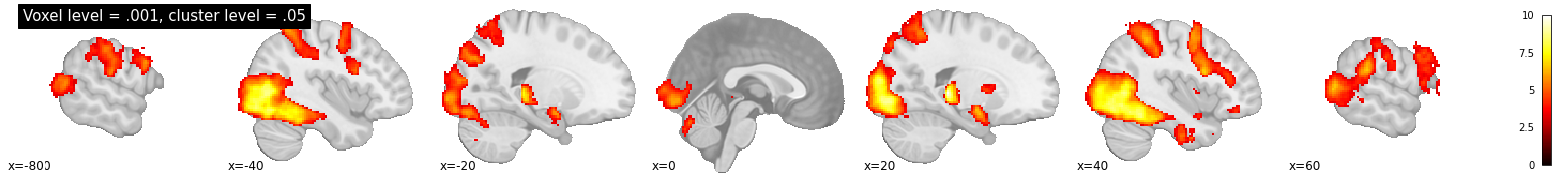

In [205]:
aon_thresholded_map = AON_second_level_dir / "AON-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(aon_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [ ]:
from nilearn import surface

In [200]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(aon_thresholded_map,
                                           cluster_extent = 10)
cluster_info

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-48.0,-78.0,6.0,5.311048,235664.0,22.14% no_label; 7.45% Occipital_Mid_L; 5.80% ...,33.45% Unknown; 17.32% Right-Cerebral-White-Ma...,10.69% Right_Occipital_Pole; 10.65% Left_Occip...
1,2.0,46.0,10.0,24.0,4.431767,34048.0,25.54% Frontal_Inf_Tri_R; 22.16% Frontal_Inf_O...,41.80% Unknown; 21.03% Right-Cerebral-White-Ma...,28.29% Right_Middle_Frontal_Gyrus; 25.99% Righ...
2,3.0,-34.0,-58.0,60.0,4.198970,28024.0,32.86% Parietal_Inf_L; 22.21% Parietal_Sup_L; ...,33.40% Left-Cerebral-White-Matter; 31.49% Unkn...,31.69% Left_Superior_Parietal_Lobule; 25.89% L...
3,4.0,20.0,-32.0,2.0,4.551783,17296.0,29.42% no_label; 13.09% Fusiform_R; 11.75% Hip...,25.12% Right-Cerebral-White-Matter; 15.08% Unk...,17.44% Right_Amygdala; 16.70% Right_Thalamus; ...
4,5.0,-52.0,4.0,42.0,4.090968,15976.0,62.09% Precentral_L; 16.22% Frontal_Inf_Oper_L...,45.22% Unknown; 21.23% Left-Cerebral-White-Mat...,53.33% Left_Precentral_Gyrus; 28.99% Left_Midd...
5,6.0,-16.0,-32.0,0.0,4.471289,8488.0,33.84% no_label; 14.99% Amygdala_L; 13.10% Tha...,23.94% Left-Cerebral-White-Matter; 20.26% Left...,30.54% Left_Thalamus; 23.94% Left_Amygdala; 8....


### Binarize the results to get mask

In [208]:
aon_masker = nilearn.image.binarize_img(aon_thresholded_map, mask_img=None)

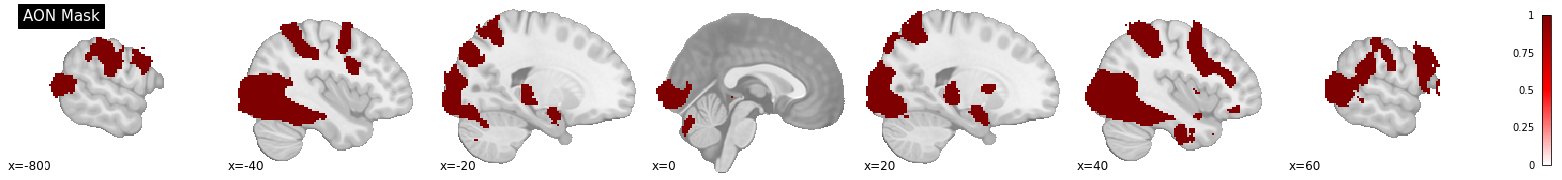

In [224]:
plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="AON Mask", bg_img = template, cmap="seismic", black_bg = False)

In [227]:
# save the mask to path
aon_mask_path = f"{masks_templates_dir}/AON_mask.nii.gz"
aon_masker.to_filename(aon_mask_path)

## Action Second Level Model

**Load the contrast maps**

In [206]:
## Action contrasts

## contrasts to baseline

# all action - baseline
cmaps_action = sorted(
    glob(f"{action_first_level_dir}/action-baseline/*.nii.gz",
         recursive=True)
)

# hand - baseline
cmaps_hand = sorted(
    glob(f"{action_first_level_dir}/hand-baseline/*.nii.gz",
         recursive=True)
)

# mouth - baseline
cmaps_mouth = sorted(
    glob(f"{action_first_level_dir}/mouth-baseline/*.nii.gz",
         recursive=True)
)

## comparisons

# hand vs. mouth
cmaps_hand_mouth = sorted(
    glob(f"{action_first_level_dir}/hand-mouth/*.nii.gz",
         recursive=True)
)

# mouth vs. hand
cmaps_mouth_hand = sorted(
    glob(f"{action_first_level_dir}/mouth-hand/*.nii.gz",
         recursive=True)
)

**We do one-sample t-tests again, so we can re-use the design matrix from above**

It includes only an intercept per subject --> one sample t-test

<AxesSubplot:label='conditions', ylabel='scan number'>

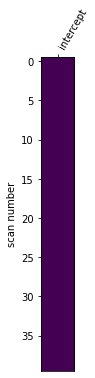

In [124]:
plot_design_matrix(design_matrix)

**Now we can fit the second level model**

In [126]:
# create and fit second level object
second_level_action = SecondLevelModel(n_jobs=2, verbose=1, minimize_memory=False)
second_level_action = second_level_action.fit(cmaps_action, design_matrix = design_matrix)

Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


In [127]:
# compute the contrast
action_avg = second_level_action.compute_contrast(second_level_contrast = "intercept",
                                            output_type = "z_score")

In [213]:
# save the second level contrast image
action_avg_image_path = f"{action_second_level_dir}/action-baseline_z_map.nii.gz"
action_avg.to_filename(action_avg_image_path)

In [212]:
# use the default masker on the aon inputs
action_brain_mask_fit = default_masker.fit(cmaps_action, y=None)

In [214]:
# and store the mask
action_brain_mask = action_brain_mask_fit.mask_img_
action_brain_mask_path = f"{masks_templates_dir}/action_brain_mask.nii.gz"
action_brain_mask.to_filename(action_brain_mask_path)

In [215]:
# use the mask to run FSL smoothest
action_smooth = fsl.SmoothEstimate(mask_file=f"{masks_templates_dir}/action_brain_mask.nii.gz", zstat_file=f"{action_second_level_dir}/action-baseline_z_map.nii.gz")
action_smooth_dict = action_smooth.run()

230401-18:52:34,614 nipype.interface INFO:
	 stdout 2023-04-01T18:52:34.614398:DLH 0.00960947
230401-18:52:34,617 nipype.interface INFO:
	 stdout 2023-04-01T18:52:34.614398:VOLUME 241156
230401-18:52:34,618 nipype.interface INFO:
	 stdout 2023-04-01T18:52:34.614398:RESELS 480.429


In [217]:
# create fsl cluster object with the inputs from above
action_cluster = fsl.Cluster(in_file = action_avg_image_path,
                          dlh = 0.00960947,
                          volume = 241156,
                          threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                          pthreshold = 0.05, # cluster level threshold of alpha = .05
                          out_threshold_file =True,
                          out_index_file = True,
                          out_localmax_txt_file = True,
                          minclustersize = True)

In [218]:
# change the working directory to the directory in which I want to have my output
os.chdir(action_second_level_dir)

# run fsl cluster to create the thresholded map
action_cluster.run()

230401-18:54:08,26 nipype.interface INFO:
	 stdout 2023-04-01T18:54:08.025913:Minimum cluster size under p-threshold = 391
230401-18:54:08,28 nipype.interface INFO:
	 stdout 2023-04-01T18:54:08.028523:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230401-18:54:08,29 nipype.interface INFO:
	 stdout 2023-04-01T18:54:08.028523:2	46686	0	45.7	10.8	67	54	65	54.8	45.6	44.7
230401-18:54:08,30 nipype.interface INFO:
	 stdout 2023-04-01T18:54:08.028523:1	14521	2.3e-21	20.6	9.47	16	62	56	20.7	57.7	45.8


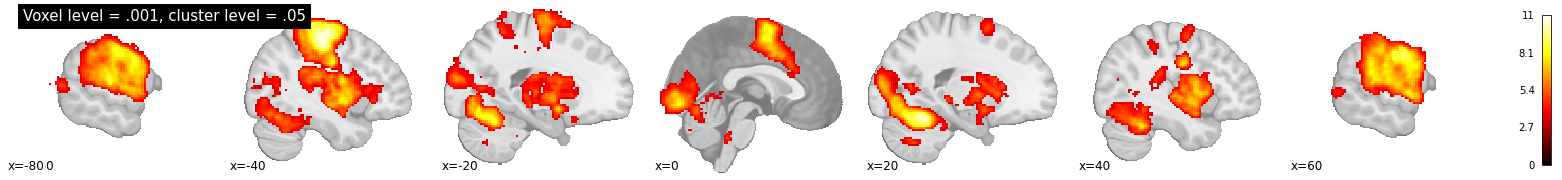

In [219]:
action_thresholded_map = action_second_level_dir / "action-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(action_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [221]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(action_thresholded_map,
                                           cluster_extent = 0)
cluster_info.head()

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-44.0,-18.0,58.0,5.218889,373056.0,17.00% no_label; 7.57% Postcentral_L; 5.85% Pr...,26.96% Unknown; 20.40% Left-Cerebral-White-Mat...,9.99% no_label; 9.23% Left_Precentral_Gyrus; 8...
1,2.0,58.0,-2.0,40.0,5.149233,116160.0,20.34% no_label; 12.09% Temporal_Sup_R; 10.96%...,31.89% Unknown; 25.88% Right-Cerebral-White-Ma...,15.00% Right_Precentral_Gyrus; 9.37% Right_Pos...
2,3.0,-20.0,14.0,-22.0,3.497942,200.0,88.00% OFCpost_L; 12.00% OFCmed_L,92.00% ctx-lh-lateralorbitofrontal,100.00% Left_Frontal_Orbital_Cortex
3,4.0,-2.0,-44.0,4.0,3.233980,40.0,60.00% no_label; 40.00% Vermis_4_5,100.00% Unknown,80.00% Left_Cingulate_Gyrus_posterior_division...
4,5.0,-18.0,-38.0,-38.0,3.507352,24.0,100.00% no_label,100.00% Left-Cerebellum-White-Matter,66.67% Brain-Stem; 33.33% no_label


### Binarize the results to get mask

In [222]:
action_masker = nilearn.image.binarize_img(action_thresholded_map, threshold=0, mask_img=None)

/usr/local/lib/python3.8/dist-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


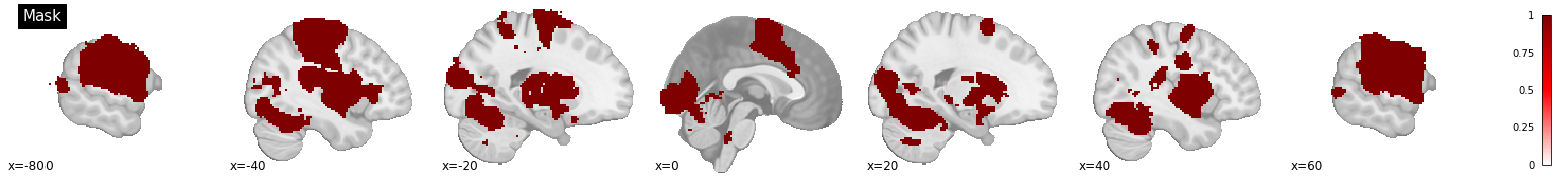

In [223]:
plotting.plot_stat_map(action_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Action Mask", bg_img = template, cmap="seismic", black_bg = False)

In [232]:
# save the mask to path
action_mask_path = f"{masks_templates_dir}/action_mask.nii.gz"
action_masker.to_filename(action_mask_path)

## Conjunction of the Masks from the Action Observation and the Action Contrasts

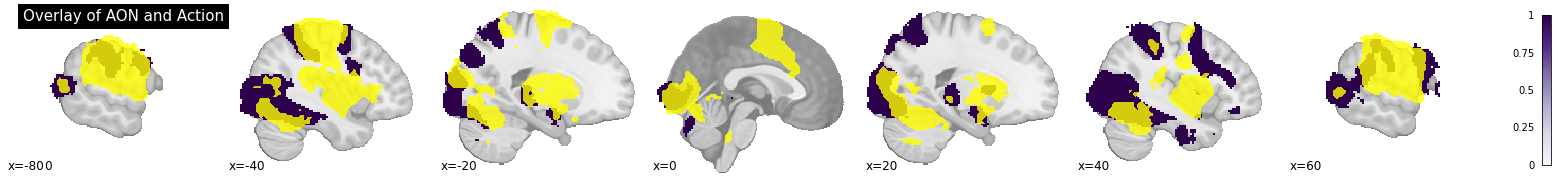

In [245]:
# Visually overlay the action map on top of the action map
aon_plot = plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of AON and Action", bg_img = template, cmap="PuOr", black_bg = False)
aon_plot.add_contours(action_masker, filled=True, alpha=0.8, colors="yellow")

In [233]:
conjunction = math_img("aon_img * action_img", aon_img=aon_masker, action_img=action_masker)

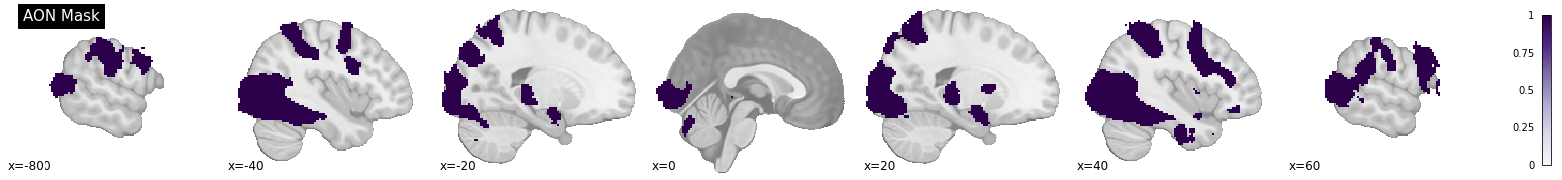

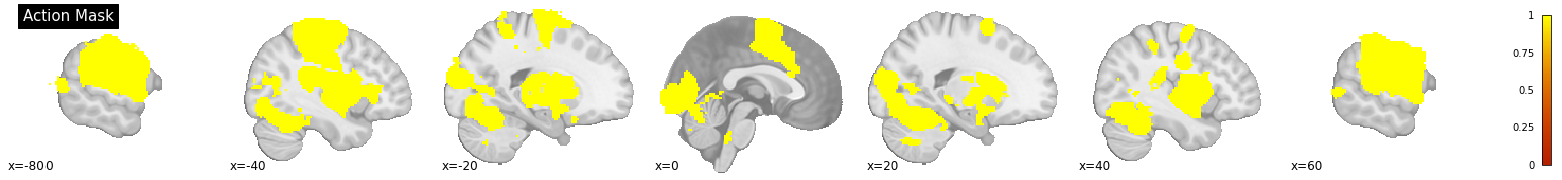

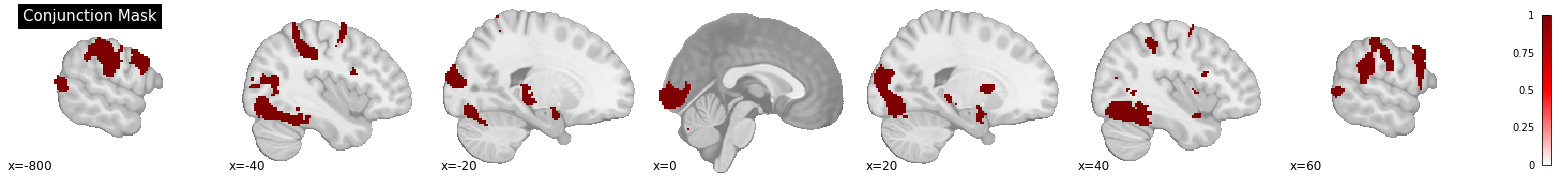

In [244]:
# plot the two individual and the conjunction mask
plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="AON Mask", bg_img = template, cmap="PuOr", black_bg = False)

plotting.plot_stat_map(action_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Action Mask", bg_img = template, cmap="gnuplot", black_bg = False)

plotting.plot_stat_map(conjunction, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Conjunction Mask", bg_img = template, cmap="seismic", black_bg = False)

In [235]:
# save the conjunction mask to path 
conjunction_mask_path = f"{masks_templates_dir}/conjunction_mask.nii.gz"
conjunction.to_filename(conjunction_mask_path)